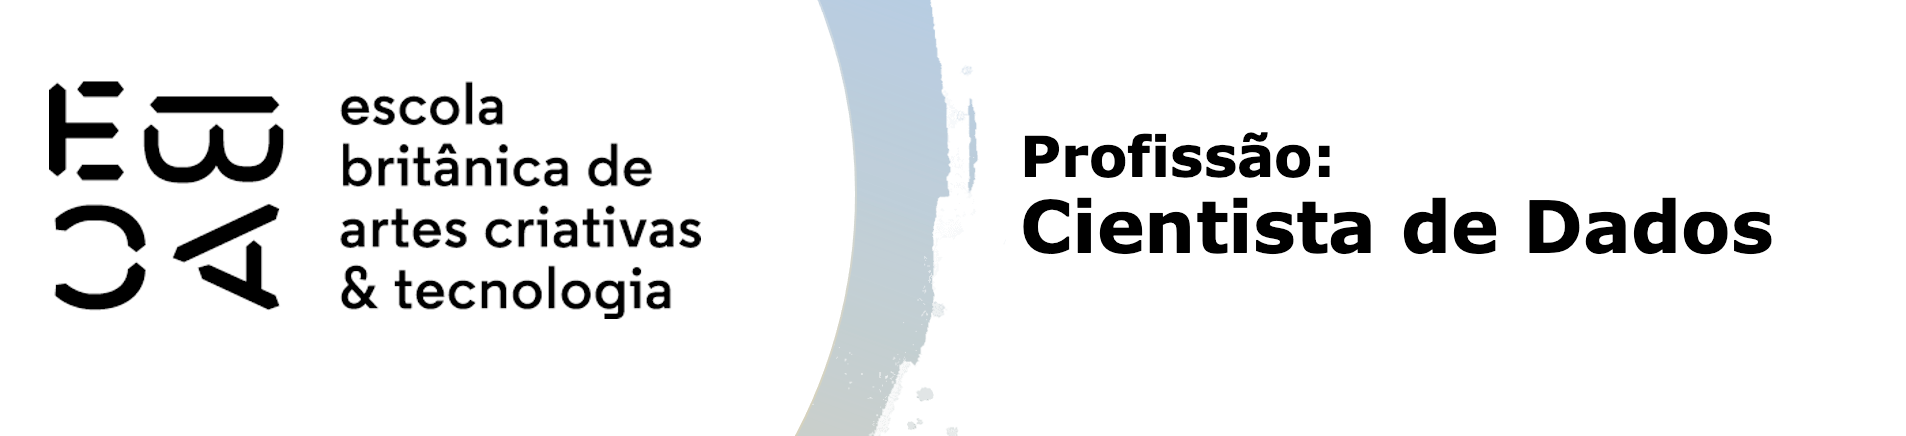

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import locale
locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')

import warnings
warnings.filterwarnings("ignore")


In [656]:
df_all= pd.read_pickle('base_nfp.pkl')
df = df_all[df_all['Ano'] >= 2020].copy()
df

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,0.0,0,não definido
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,0.0,0,Farmácia
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado


In [658]:
df.columns=['CNPJ emit.', 'Emitente', 'No.', 'Data_Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria']


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)



In [661]:
df['Data_Emissão'] = pd.to_datetime(df['Data_Emissão'])

# Dia da semana
df['dia_da_semana'] = df['Data_Emissão'].dt.strftime('%A')

# Dummy para fim de semana (1 se sábado ou domingo, 0 caso contrário)
df['fim_de_semana'] = df['dia_da_semana'].isin(['sábado', 'domingo']).astype(int)

# Dia do mês (1 a 31)
df['dia_do_mes'] = df['Data_Emissão'].dt.day

# Mês (1 a 12)
df['mes'] = df['Data_Emissão'].dt.month

# Trimestre (1 a 4)
df['trimestre'] = df['Data_Emissão'].dt.quarter

df

,CNPJ emit.,Emitente,No.,Data_Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,dia_da_semana,fim_de_semana,dia_do_mes,mes,trimestre
100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,terÃ§a-feira,0,30,6,2
100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,terÃ§a-feira,0,30,6,2
100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,terÃ§a-feira,0,30,6,2
100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,terÃ§a-feira,0,30,6,2
100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo,terÃ§a-feira,0,30,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,0.0,0,não definido,quinta-feira,0,7,1,1
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado,quinta-feira,0,7,1,1
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,0.0,0,Farmácia,quinta-feira,0,7,1,1
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado,quinta-feira,0,7,1,1


**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [664]:
df['cat_valor_nf_5'] = pd.qcut(df['Valor NF'], q=5, labels=False, duplicates='drop')
df['cat_valor_nf_10'] = pd.qcut(df['Valor NF'], q=10, labels=False, duplicates='drop')
df['cat_valor_nf_20'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')
df['cat_valor_nf_50'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')

df

,CNPJ emit.,Emitente,No.,Data_Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,dia_da_semana,fim_de_semana,dia_do_mes,mes,trimestre,cat_valor_nf_5,cat_valor_nf_10,cat_valor_nf_20,cat_valor_nf_50
100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,...,Farmácia,terÃ§a-feira,0,30,6,2,3,7,15,39
100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,...,não definido,terÃ§a-feira,0,30,6,2,2,4,9,24
100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,...,não definido,terÃ§a-feira,0,30,6,2,4,9,18,45
100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,...,Farmácia,terÃ§a-feira,0,30,6,2,2,4,8,21
100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,...,Varejo,terÃ§a-feira,0,30,6,2,1,2,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,...,não definido,quinta-feira,0,7,1,1,4,8,17,42
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,...,Mercado,quinta-feira,0,7,1,1,4,9,18,45
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,...,Farmácia,quinta-feira,0,7,1,1,3,7,14,35
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,...,Mercado,quinta-feira,0,7,1,1,1,3,7,18


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [667]:
df.drop(columns=['CNPJ emit.', 'Emitente', 'No.', 'Data Registro'], inplace=True)
metadados = pd.DataFrame({'dtype':df.dtypes})
metadados

,dtype
Data_Emissão,datetime64[ns]
Valor NF,float64
Créditos,float64
Situação do Crédito,category
Ano,int64
Semestre,int64
Retorno,float64
flag_credito,int64
categoria,object
dia_da_semana,object


In [669]:
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados.loc['Data_Emissão','papel'] = 'data'
metadados['nunique'] = df.nunique()
metadados

,dtype,papel,nunique
Data_Emissão,datetime64[ns],data,731
Valor NF,float64,covariavel,28381
Créditos,float64,covariavel,7845
Situação do Crédito,category,covariavel,2
Ano,int64,covariavel,2
Semestre,int64,covariavel,2
Retorno,float64,covariavel,35839
flag_credito,int64,resposta,2
categoria,object,covariavel,9
dia_da_semana,object,covariavel,7


In [671]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[1]
    rótulo_nao_evento = tab.columns[0]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log((tab.pct_evento/tab.pct_nao_evento)+0.01)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [673]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>9):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.flag_credito)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.flag_credito)
    
metadados

,dtype,papel,nunique,IV
Data_Emissão,datetime64[ns],data,731,NaN
Valor NF,float64,covariavel,28381,0.038647
Créditos,float64,covariavel,7845,inf
Situação do Crédito,category,covariavel,2,0.000027
Ano,int64,covariavel,2,0.003137
Semestre,int64,covariavel,2,0.004858
Retorno,float64,covariavel,35839,inf
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.275170
dia_da_semana,object,covariavel,7,0.005803


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<div style="background-color: #e6f7ff; padding: 20px; border: 3px solid #00b3b3; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
   <strong>Resposta:</strong> <br>
    <p>A variavel categoria parece apresentar maior poder de discriminação segundo o IV.
Quando categorizamos variáveis contínuas não aparenta haver alguma relação entre o número de categorias e o IV.
</p>
</div>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período

<Axes: xlabel='trimestre', ylabel='count'>

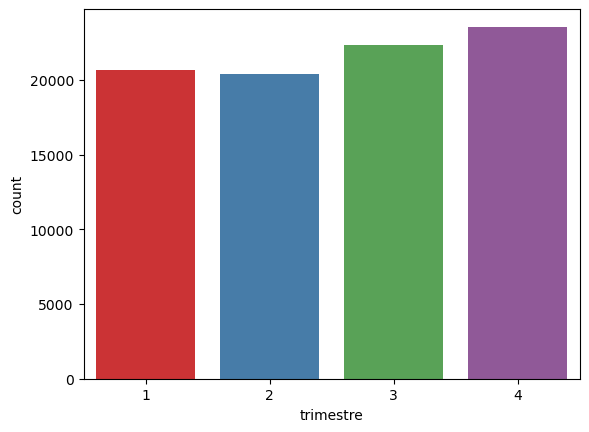

In [562]:
sns.countplot(x=df["trimestre"], palette='Set1')

- A quantidade de notas por categoria e por período

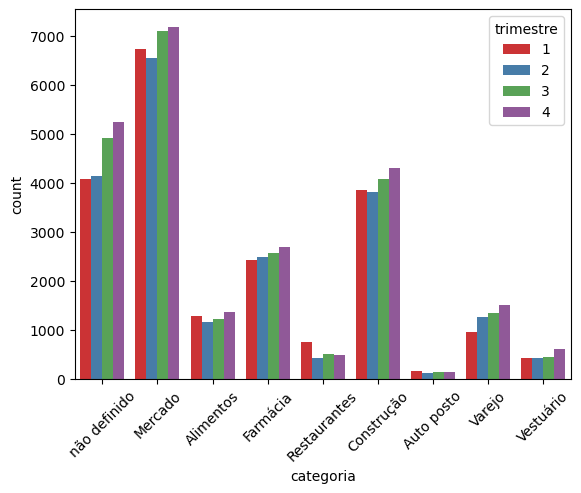

In [564]:
sns.countplot(x=df["categoria"], hue=df["trimestre"], palette='Set1')
plt.xticks(rotation=45);

- A proporção de notas com crédito por categoria por período

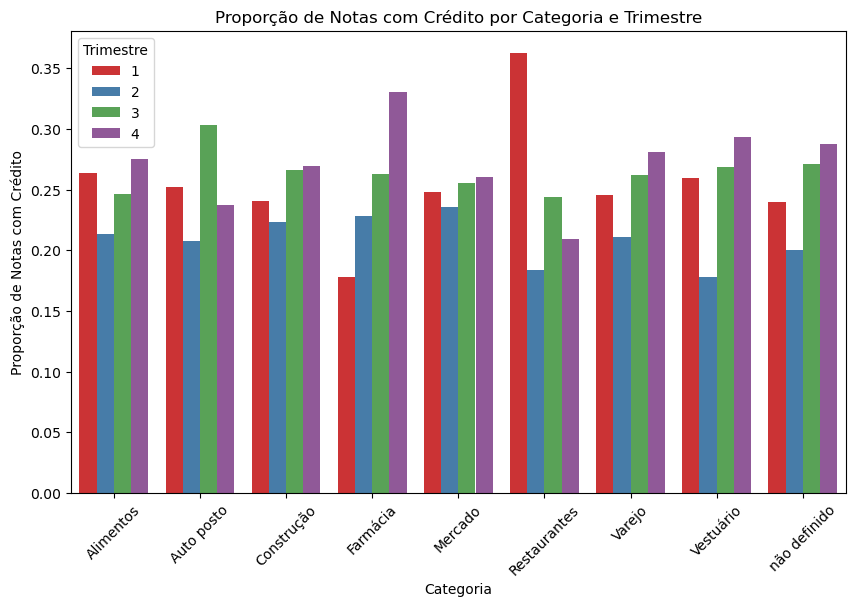

In [629]:
tab = pd.crosstab([df['trimestre'], df['categoria']], df['flag_credito'], margins=True, margins_name='total')

# Remover a linha total
tab = tab.drop('total')

# Calcular as proporções de notas com crédito por categoria e trimestre
tab['pct_credito'] = tab[1] / tab[1].groupby(level=1).sum() 

# Resetando o índice para facilitar a visualização
tab_reset = tab.reset_index()

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=tab_reset, x='categoria', y='pct_credito', hue='trimestre', palette='Set1')

# Título e labels
plt.title('Proporção de Notas com Crédito por Categoria e Trimestre')
plt.xlabel('Categoria')
plt.ylabel('Proporção de Notas com Crédito')

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.legend(title='Trimestre')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [568]:
tab = pd.crosstab([df.Data_Emissão, df.categoria ], df.flag_credito, margins=True, margins_name = 'total')

rótulo_evento = tab.columns[1]
rótulo_nao_evento = tab.columns[0]

tab['pct_evento'] = tab[rótulo_evento]/tab[rótulo_evento].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab[rótulo_nao_evento].groupby(level=0).sum()
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)

tab

flag_credito                          0      1  total  pct_evento  \
Data_Emissão        categoria                                       
2020-01-01 00:00:00 Alimentos         3      3      6    0.428571   
                    Auto posto        2      0      2    0.000000   
                    Construção        1      1      2    0.142857   
                    Farmácia          6      0      6    0.000000   
                    Mercado           3      1      4    0.142857   
...                                 ...    ...    ...         ...   
2021-12-31 00:00:00 Restaurantes      2      2      4    0.044444   
                    Varejo            2      0      2    0.000000   
                    Vestuário         3      0      3    0.000000   
                    não definido      5     11     16    0.244444   
total                             49638  37318  86956    1.000000   

flag_credito                      pct_nao_evento       woe  
Data_Emissão        categoria                               
2020-01-01 00:00:00 Alimentos           0.176471  0.887303  
                    Auto posto          0.117647      -inf  
                    Construção          0.058824  0.887303  
                    Farmácia            0.352941      -inf  
                    Mercado             0.176471 -0.211309  
...                                          ...       ...  
2021-12-31 00:00:00 Restaurantes        0.038462  0.144581  
                    Varejo              0.038462      -inf  
                    Vestuário           0.057692      -inf  
                    não definido        0.096154  0.933039  
total                                   1.000000  0.000000  

[6037 rows x 6 columns]

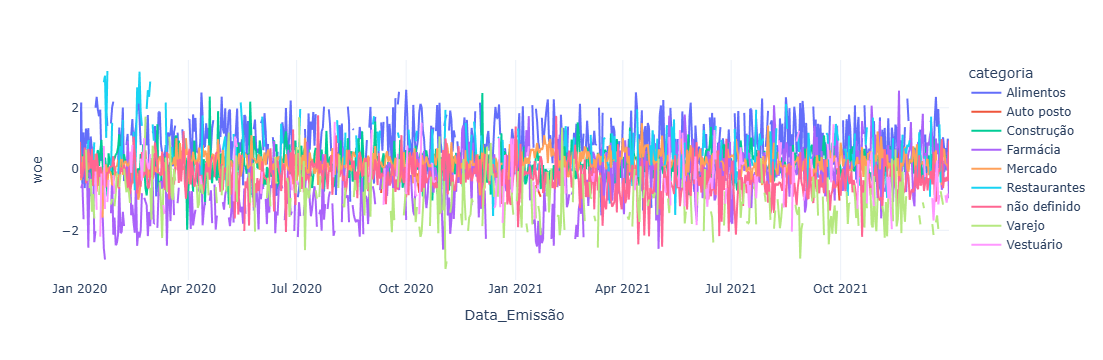

In [569]:
tab_reset = tab.reset_index()
fig = px.line(tab_reset, x='Data_Emissão', y='woe', color='categoria' , template='plotly_white')
fig.show()

In [570]:
tab = df.groupby(['mes', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
tab['total'] = tab.sum(axis=1)

tab['tx_evento'] = tab[1]/tab[0]
tab['pct_evento'] = tab[1]/tab[1].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[0]/tab[0].groupby(level=0).sum()
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)

tab

flag_credito         0     1  total  tx_evento  pct_evento  pct_nao_evento  \
mes categoria                                                                
1   Alimentos      103   377    480   3.660194    0.112269        0.028860   
    Auto posto      55    14     69   0.254545    0.004169        0.015410   
    Construção     631   638   1269   1.011094    0.189994        0.176800   
    Farmácia       591   194    785   0.328257    0.057772        0.165593   
    Mercado        970  1125   2095   1.159794    0.335021        0.271785   
...                ...   ...    ...        ...         ...             ...   
12  Mercado       1298  1141   2439   0.879045    0.320866        0.284026   
    Restaurantes    56   109    165   1.946429    0.030652        0.012254   
    Varejo         388    65    453   0.167526    0.018279        0.084902   
    Vestuário      179    58    237   0.324022    0.016310        0.039168   
    não definido  1176   708   1884   0.602041    0.199100        0.257330   

flag_credito           woe  
mes categoria               
1   Alimentos     1.358456  
    Auto posto   -1.307336  
    Construção    0.071972  
    Farmácia     -1.053018  
    Mercado       0.209182  
...                    ...  
12  Mercado       0.121957  
    Restaurantes  0.916873  
    Varejo       -1.535741  
    Vestuário    -0.876066  
    não definido -0.256553  

[108 rows x 7 columns]

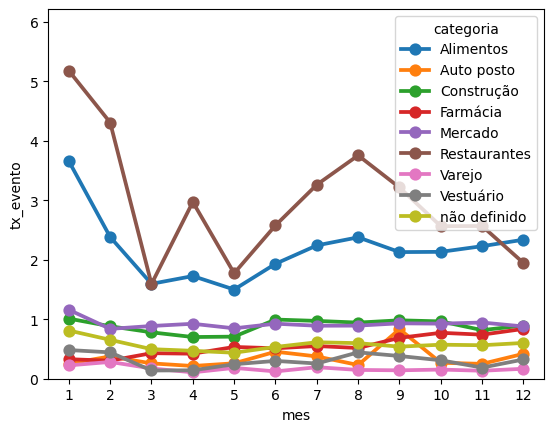

In [571]:
fig, ax = plt.subplots()
sns.pointplot(data=tab.reset_index(), x='mes', y='tx_evento', hue='categoria', ci=None, ax=ax)
ax.set_ylim([0, tab.tx_evento.max()*1.2]);

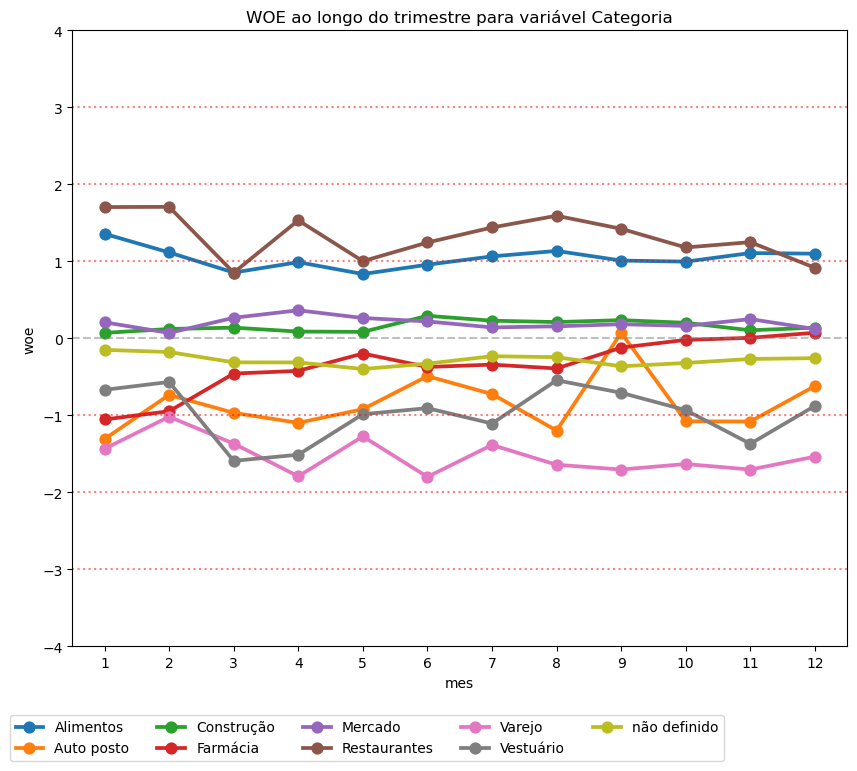

In [572]:
fig, ax = plt.subplots(figsize=(10,8))
variavel = 'categoria'

# Comando principal do gráfico
sns.pointplot(data=tab.reset_index(), y='woe', x='mes', hue=variavel, ax=ax)

# limites do gráfico - mostrando 1 e -1 para ter referência
ymax = 4
ymin = -4
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(3, linestyle=':', color='red', alpha=.5)
ax.axhline(2, linestyle=':', color='red', alpha=.5)
ax.axhline(1, linestyle=':', color='red', alpha=.5)
ax.axhline(0, linestyle='--', color='grey', alpha=.5)
ax.axhline(-1, linestyle=':', color='red', alpha=.5)
ax.axhline(-2, linestyle=':', color='red', alpha=.5)
ax.axhline(-3, linestyle=':', color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo do trimestre para variável {variavel.capitalize()}')
# ax.set_xlabel('Safra', loc='right')

ax.legend(bbox_to_anchor=(.85, -.1), ncol=5)

<Axes: xlabel='mes'>

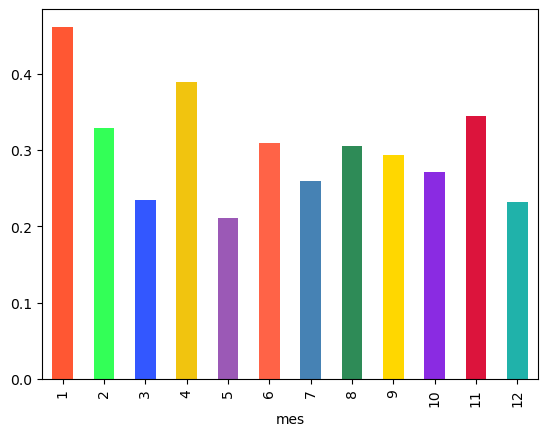

In [573]:
iv_cat = ((tab.pct_evento - tab.pct_nao_evento)*tab.woe).groupby(level=0).sum();
cores = ['#FF5733', '#33FF57', '#3357FF', '#F1C40F', '#9B59B6', 
         '#FF6347', '#4682B4', '#2E8B57', '#FFD700', '#8A2BE2', 
         '#DC143C', '#20B2AA']
iv_cat.plot.bar(color=cores)

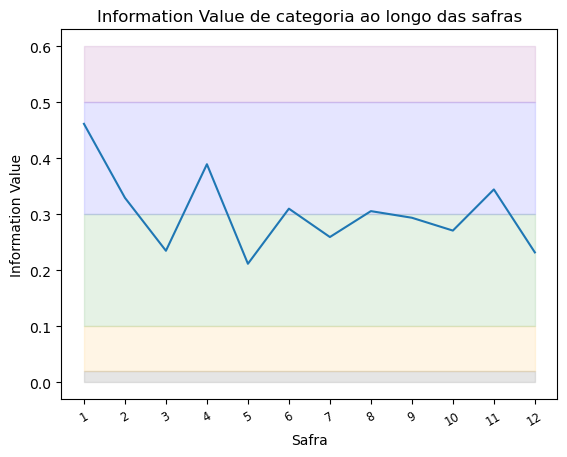

In [574]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    # Verificar se o índice é do tipo datetime
    if isinstance(IV.index, pd.DatetimeIndex):
        labs = IV.index.get_level_values(level=0).unique()
        labs2 = [x.to_period('M') for x in labs]  # Converter para períodos mensais
    else:
        labs = IV.index  # Se não for datetime, use o índice original
        labs2 = [str(x) for x in labs]  # Converte para string

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de categoria ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")
    
plot_iv(iv_cat)

In [608]:
tab = df_all.groupby(['Ano', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
tab['total'] = tab.sum(axis=1)

tab['tx_evento'] = tab[1]/tab[0]
tab['pct_evento'] = tab[1]/tab[1].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[0]/tab[0].groupby(level=0).sum()
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)

tab

flag_credito           0     1  total  tx_evento  pct_evento  pct_nao_evento  \
Ano  categoria                                                                 
2017 Alimentos        71  4875   4946  68.661972    0.279883        0.002711   
     Auto posto     2480     9   2489   0.003629    0.000517        0.094693   
     Construção     2712   505   3217   0.186209    0.028993        0.103551   
     Farmácia       1609   343   1952   0.213176    0.019692        0.061436   
     Mercado        2824  1084   3908   0.383853    0.062234        0.107827   
     Restaurantes  15291  9482  24773   0.620103    0.544379        0.583849   
     Varejo           66    11     77   0.166667    0.000632        0.002520   
     Vestuário         7   163    170  23.285714    0.009358        0.000267   
     não definido   1130   946   2076   0.837168    0.054312        0.043146   
2018 Alimentos        97   227    324   2.340206    0.046583        0.020438   
     Auto posto      194    23    217   0.118557    0.004720        0.040877   
     Construção      382   447    829   1.170157    0.091730        0.080489   
     Farmácia        134   220    354   1.641791    0.045147        0.028234   
     Mercado        1777  2105   3882   1.184581    0.431972        0.374421   
     Restaurantes   1316   934   2250   0.709726    0.191668        0.277286   
     Varejo           73    32    105   0.438356    0.006567        0.015381   
     Vestuário        36   318    354   8.833333    0.065258        0.007585   
     não definido    737   567   1304   0.769335    0.116355        0.155289   
2019 Alimentos       319  4324   4643  13.554859    0.172760        0.014212   
     Auto posto      340   104    444   0.305882    0.004155        0.015147   
     Construção     6808  5336  12144   0.783784    0.213193        0.303306   
     Farmácia       1707   741   2448   0.434095    0.029606        0.076049   
     Mercado        3907  3442   7349   0.880983    0.137520        0.174062   
     Restaurantes   5472  5076  10548   0.927632    0.202805        0.243785   
     Varejo          365   291    656   0.797260    0.011627        0.016261   
     Vestuário       293   875   1168   2.986348    0.034959        0.013054   
     não definido   3235  4840   8075   1.496136    0.193376        0.144124   
2020 Alimentos       778  1720   2498   2.210797    0.098207        0.031516   
     Auto posto      195    73    268   0.374359    0.004168        0.007899   
     Construção     4262  3448   7710   0.809010    0.196871        0.172648   
     Farmácia       3669  1213   4882   0.330608    0.069259        0.148627   
     Mercado        7617  6182  13799   0.811606    0.352975        0.308555   
     Restaurantes    237   953   1190   4.021097    0.054414        0.009601   
     Varejo         1886   362   2248   0.191941    0.020669        0.076400   
     Vestuário       657   202    859   0.307458    0.011534        0.026614   
     não definido   5385  3361   8746   0.624141    0.191904        0.218140   
2021 Alimentos       827  1722   2549   2.082225    0.086952        0.033160   
     Auto posto      209    62    271   0.296651    0.003131        0.008380   
     Construção     4261  4075   8336   0.956348    0.205767        0.170850   
     Farmácia       2935  2369   5304   0.807155    0.119622        0.117682   
     Mercado        6762  6995  13757   1.034457    0.353211        0.271131   
     Restaurantes    315   673    988   2.136508    0.033983        0.012630   
     Varejo         2479   339   2818   0.136749    0.017118        0.099399   
     Vestuário       820   241   1061   0.293902    0.012169        0.032879   
     não definido   6332  3328   9660   0.525584    0.168047        0.253889   

flag_credito            woe  
Ano  categoria               
2017 Alimentos     4.637069  
     Auto posto   -5.210916  
     Construção   -1.273010  
     Farmácia     -1.137764  
     Mercado      -0.549623  
     Restaurantes -0.069996  

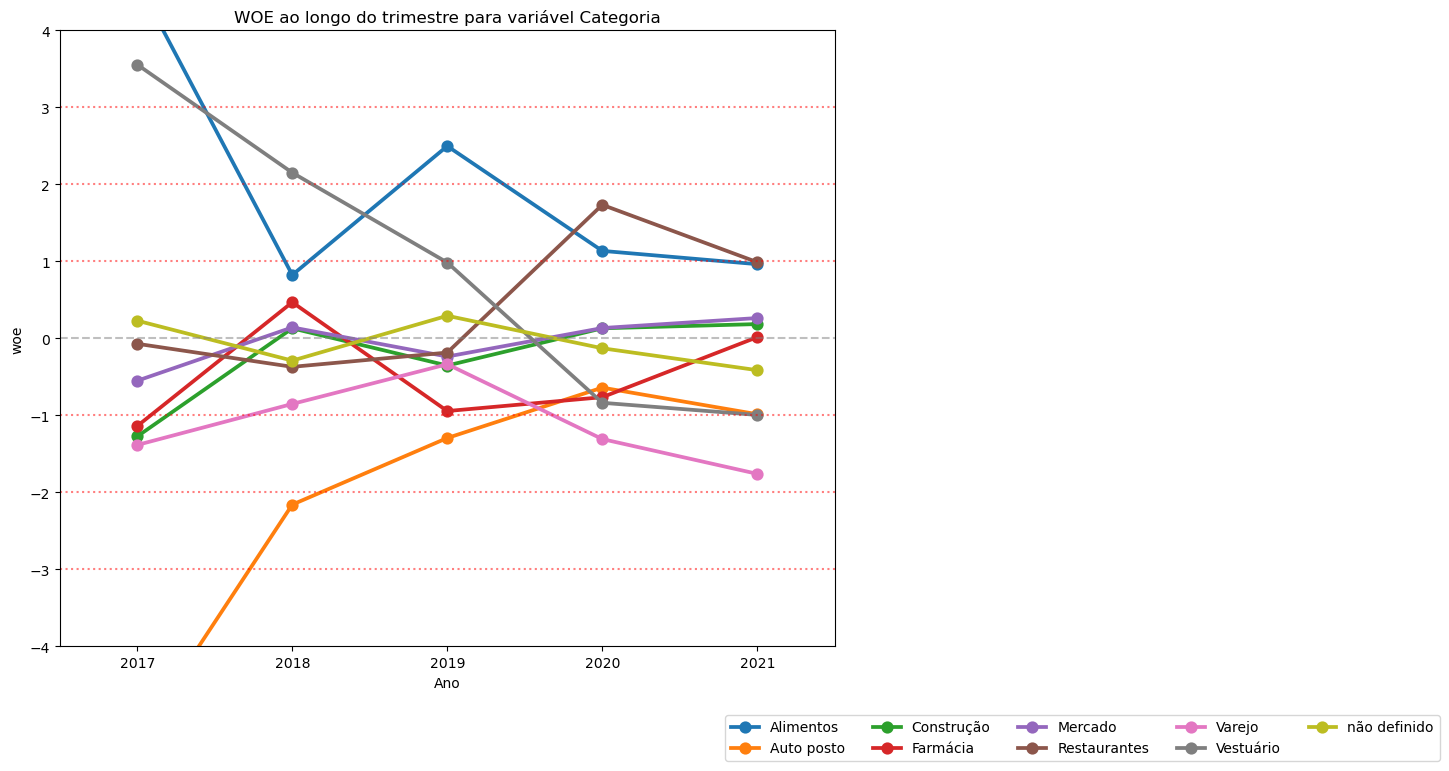

In [612]:
fig, ax = plt.subplots(figsize=(10,8))
variavel = 'categoria'

# Comando principal do gráfico
sns.pointplot(data=tab.reset_index(), y='woe', x='Ano', hue=variavel, ax=ax)

# limites do gráfico - mostrando 1 e -1 para ter referência
ymax = 4
ymin = -4
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(3, linestyle=':', color='red', alpha=.5)
ax.axhline(2, linestyle=':', color='red', alpha=.5)
ax.axhline(1, linestyle=':', color='red', alpha=.5)
ax.axhline(0, linestyle='--', color='grey', alpha=.5)
ax.axhline(-1, linestyle=':', color='red', alpha=.5)
ax.axhline(-2, linestyle=':', color='red', alpha=.5)
ax.axhline(-3, linestyle=':', color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo do trimestre para variável {variavel.capitalize()}')
# ax.set_xlabel('Safra', loc='right')

ax.legend(bbox_to_anchor=(.85, -.1), ncol=5)

<Axes: xlabel='Ano'>

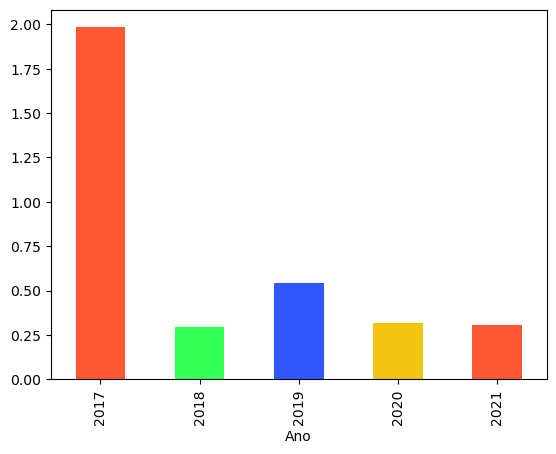

In [620]:
iv_cat = ((tab.pct_evento - tab.pct_nao_evento)*tab.woe).groupby(level=0).sum();
cores = ['#FF5733', '#33FF57', '#3357FF', '#F1C40F']
iv_cat.plot.bar(color=cores)

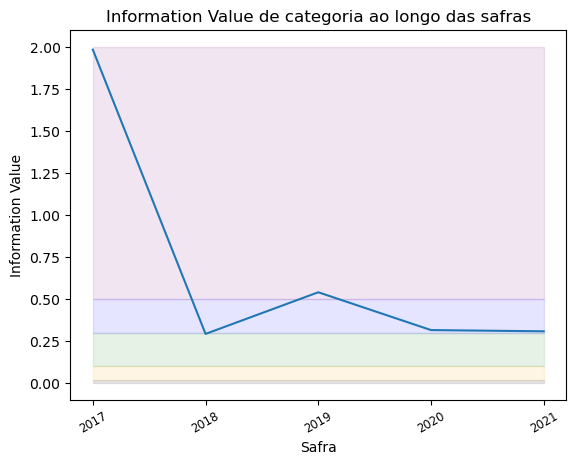

In [618]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [2]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    # Verificar se o índice é do tipo datetime
    if isinstance(IV.index, pd.DatetimeIndex):
        labs = IV.index.get_level_values(level=0).unique()
        labs2 = [x.to_period('M') for x in labs]  # Converter para períodos mensais
    else:
        labs = IV.index  # Se não for datetime, use o índice original
        labs2 = [str(x) for x in labs]  # Converte para string

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de categoria ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")
    
plot_iv(iv_cat)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<div style="background-color: #e6f7ff; padding: 20px; border: 3px solid #00b3b3; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
   <strong>Resposta:</strong> <br>
    <p>Pode se notar uma instabilidade pelos gráficos por anos onde a partir do ano 2020 se estabiliza, com os dados selecionados a partir do ano 2020 pode se reparar uma estabilidade em relação ao tempo para a maioria das variáveis onde apenas a categoria auto posto, farmácia e vestuário apresenta variância significantes.</p><p>
As categorias parecem ter maior proporção de notas com retornos maiores que zero são alimentos e restaurantes.</p>
   
</div>